In [52]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

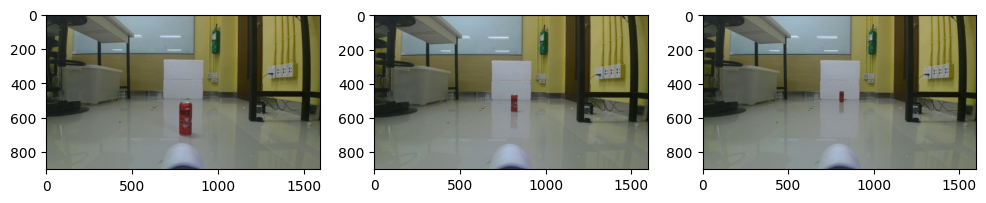

In [ ]:
# โหลดภาพ BGR เเล้วแปลงเป็น RGB
img1_bgr = cv2.imread('img/box1.png', cv2.IMREAD_COLOR)
img2_bgr = cv2.imread('img/box2.png', cv2.IMREAD_COLOR)
img3_bgr = cv2.imread('img/box3.png', cv2.IMREAD_COLOR)

# แปลง BGR เป็น RGB
img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img1_rgb)

plt.subplot(1,3,2)
plt.imshow(img2_rgb)

plt.subplot(1,3,3)
plt.imshow(img3_rgb)

plt.show()

In [ ]:
# เบลอภาพก่อนลด noise
img1_blur = cv2.GaussianBlur(img1_rgb, (7,7), 0)
img2_blur = cv2.GaussianBlur(img2_rgb, (7,7), 0)
img3_blur = cv2.GaussianBlur(img3_rgb, (7,7), 0)

# แปลงภาพ RGB เป็น HSV เพื่อให้ Hue แยกสีง่าย
img1_hsv = cv2.cvtColor(img1_blur, cv2.COLOR_RGB2HSV)
img2_hsv = cv2.cvtColor(img2_blur, cv2.COLOR_RGB2HSV)
img3_hsv = cv2.cvtColor(img3_blur, cv2.COLOR_RGB2HSV)

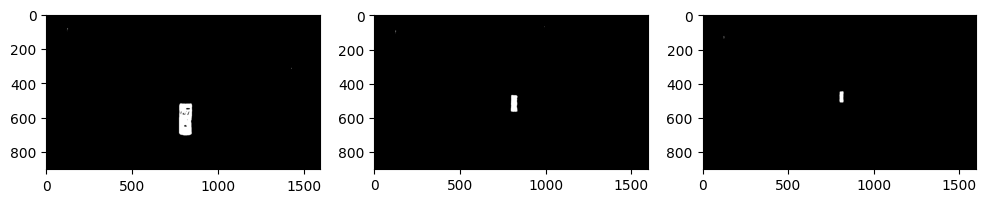

In [ ]:
# ขั้นตอนการจตัดเอางสีแดงออกมา เพื่อสร้าง binary mask

# กำหนดช่วงสีแดงใน HSV (มี 2 ช่วงเพราะสีแดงอยู่ที่ hue รอบวง)
lower_red_1 = np.array([0, 50, 50], dtype=np.uint8)
upper_red_1 = np.array([10, 255, 255], dtype=np.uint8)
lower_red_2 = np.array([170, 50, 50], dtype=np.uint8)
upper_red_2 = np.array([180, 255, 255], dtype=np.uint8)

# สร้าง binary mask โดยใช้ inRange แล้วรวม 2 ช่วงเข้าด้วยกัน
img1_bi1 = cv2.inRange(img1_hsv, lower_red_1, upper_red_1)
img1_bi2 = cv2.inRange(img1_hsv, lower_red_2, upper_red_2)
# รวม 2 ช่วง
img1_bi = cv2.bitwise_or(img1_bi1, img1_bi2)

img2_bi1 = cv2.inRange(img2_hsv, lower_red_1, upper_red_1)
img2_bi2 = cv2.inRange(img2_hsv, lower_red_2, upper_red_2)
# รวม 2 ช่วง
img2_bi = cv2.bitwise_or(img2_bi1, img2_bi2)

img3_bi1 = cv2.inRange(img3_hsv, lower_red_1, upper_red_1)
img3_bi2 = cv2.inRange(img3_hsv, lower_red_2, upper_red_2)
# รวม 2 ช่วง
img3_bi = cv2.bitwise_or(img3_bi1, img3_bi2)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img1_bi, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(img2_bi, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(img3_bi, cmap='gray')

plt.show()

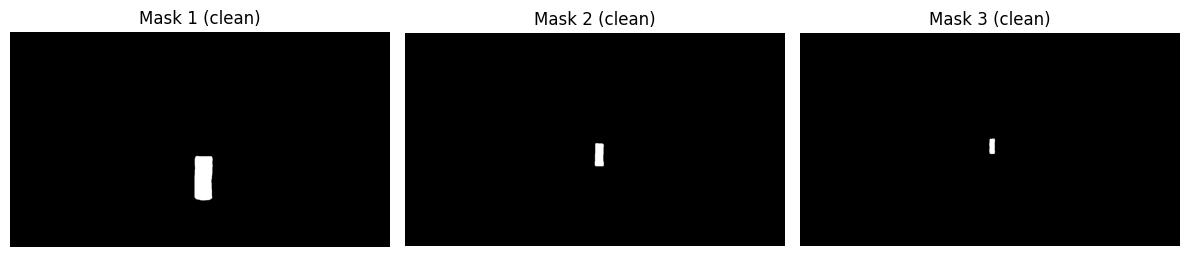

In [ ]:
# ใช้ morphological operations เพื่อลด noise ใน binary mask
# สร้าง kernel ซึ่ง kernal เป็นสี่เหลียมเพื่อให้เข้ากับกระป๋องโค้กซึ่งเป็นรูปร่างค่อนข้างสี่เหลี่ยม สำหรับทำ morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))

# ฟังก์ชันทำความสะอาด mask
def clean(mask, open_iter=1, close_iter=2): # MORPH_OPEN = ตัด noise สีขาวเล็กๆออก, 1 ครั้ง, MORPH_CLOSE = ตัด noise สีดำเล็กๆออก, 2 ครั้ง ***เน้นอุดรูมากกว่าตัดจุด open 1 รอบ, close 2 รอบ ***
    m = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=open_iter)
    m = cv2.morphologyEx(m,    cv2.MORPH_CLOSE, kernel, iterations=close_iter)
    return m

# ได้ mask ที่ผ่าน morphological operations แล้ว
mask_1_clean = clean(img1_bi)
mask_2_clean = clean(img2_bi)
mask_3_clean = clean(img3_bi)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(mask_1_clean, cmap='gray'); plt.title('Mask 1 (clean)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask_2_clean, cmap='gray'); plt.title('Mask 2 (clean)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(mask_3_clean, cmap='gray'); plt.title('Mask 3 (clean)'); plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# บันทึก mask ที่ได้เป็นไฟล์ภาพ PNG เพื่อใช้เป็น template ในการตรวจจับ

import cv2, numpy as np, os

os.makedirs("templates", exist_ok=True)

def save_bin(path, m):
    cv2.imwrite(path, m)

save_bin("templates/coke_near.png",  mask_1_clean)
save_bin("templates/coke_mid.png",   mask_2_clean)
save_bin("templates/coke_far.png",   mask_3_clean)



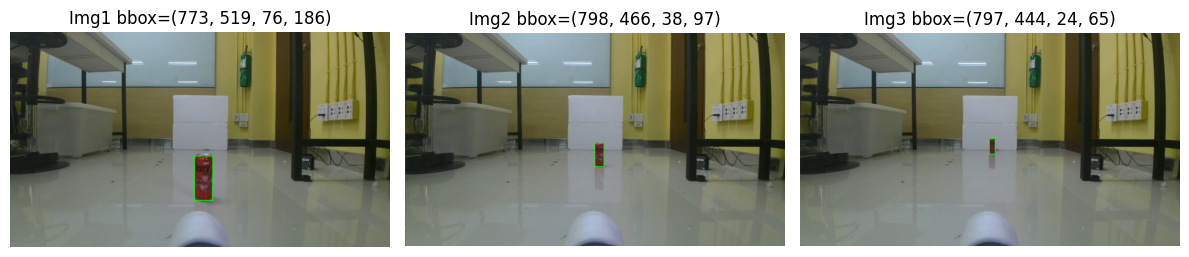

In [ ]:
# วาด bbox จาก mask
def draw_bbox(mask_clean, bgr, area_thresh=150, color=(0,255,0), thickness=2): # color สีเขียว, thickness = ความหนาของเส้น
    annot = bgr.copy() # ภาพสำหรับวาด ภาพต้นไม่เปลี่ยนแปลง

    # รองรับ OpenCV หลายเวอร์ชัน
    found = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL = ดึง contour ภายนอกสุด, CHAIN_APPROX_SIMPLE = เก็บเฉพาะจุดสำคัญ (มุม)
    cnts = found[-2] # OpenCV 3,4 = found[1], OpenCV 2 = found[0]

    bbox = None # ถ้าไม่เจอ contour จะคืนค่า None
    if len(cnts) > 0: # ถ้ามี contour อย่างน้อย 1 อัน
        c = max(cnts, key=cv2.contourArea) # หา contour ที่มีพื้นที่มากที่สุด
        if cv2.contourArea(c) > area_thresh: # ถ้าพื้นที่มากกว่า threshold
            x, y, w, h = cv2.boundingRect(c) # สร้างกรอบสี่เหลี่ยมชิดแกน รอบคอนทัวร์นั้น
            bbox = (x, y, w, h) # เก็บค่า bbox
            cv2.rectangle(annot, (x, y), (x+w, y+h), color, thickness) 
            ''' วาดสี่เหลี่ยมบนภาพ annot (ภาพต้นไม่เปลี่ยนแปลง) , cv2.rectangle() เก็บ สองมุมตรงข้าม มุมซ้ายบน = (x, y) มุมขวาล่าง = (x+w, y+h)'''

    return annot, bbox # 

# ใช้กับ 3 ภาพ 3 ระยะ ในการวาด bbox ครอบกระป๋องโค้ก
ann1, b1 = draw_bbox(mask_1_clean, img1_bgr)
ann2, b2 = draw_bbox(mask_2_clean, img2_bgr)
ann3, b3 = draw_bbox(mask_3_clean, img3_bgr)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(ann1, cv2.COLOR_BGR2RGB)); plt.title(f'Img1 bbox={b1}'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(ann2, cv2.COLOR_BGR2RGB)); plt.title(f'Img2 bbox={b2}'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(ann3, cv2.COLOR_BGR2RGB)); plt.title(f'Img3 bbox={b3}'); plt.axis('off')
plt.tight_layout(); plt.show()
